In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

#The objective of this task is to detect hate speech in tweets.
#For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it.
#So, the task is to classify racist or sexist tweets from other tweets.

#Formally, given a training sample of tweets and labels, where label ‘1’ denotes the tweet is racist/sexist and
#label ‘0’ denotes the tweet is not racist/sexist, our objective is to predict the labels on the given test dataset.


#Note: The evaluation metric from this practice problem is F1-Score.

In [2]:
#importing the libraries
import re
import nltk
import string
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

In [3]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [4]:
test.shape,train.shape

((17197, 2), (31962, 3))

In [5]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [6]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

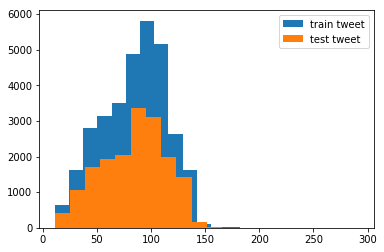

In [7]:
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()

plt.hist(length_train,bins=20,label='train tweet')
plt.hist(length_test,bins=20,label='test tweet')
plt.legend()
plt.show

#Data cleaning

In [8]:
#Combine train and test dataset for data cleaning

combi = train.append(test,ignore_index=True)
combi.shape

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(49159, 3)

In [9]:
combi.head()

,id,label,tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation


In [10]:
#function to handle @user
def remove_pattern(input_txt,pattern):
    
    r = re.findall(pattern,input_txt)
    
    for x in r:
        input_txt = re.sub(x, '',input_txt)
    
    return input_txt

In [11]:
#Removing Twitter Handles (@user)

combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'],'@[\w]*')
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


In [12]:
# Removing Punctuations, Numbers, and Special Characters
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


In [13]:
#Removing Short Words
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [14]:
combi.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [15]:
#tokenization of the tweet

tokenize_tweet  = combi['tidy_tweet'].apply(lambda x : x.split())

In [16]:
tokenize_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [17]:
#normalization the tokenized tweets.
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenize_tweet = tokenize_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

In [18]:
tokenize_tweet.head()

0                   [when, father, dysfunct, selfish, drag, kid, into, dysfunct, #run]
1    [thank, #lyft, credit, caus, they, offer, wheelchair, van, #disapoint, #getthank]
2                                                              [bihday, your, majesti]
3                                                     [#model, love, take, with, time]
4                                                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [19]:
#Replaceing the tidy_tweet tweets with the tokenized tweet
for i in range(len(tokenize_tweet)):
    tokenize_tweet[i] = ' '.join(tokenize_tweet[i])    
combi['tidy_tweet'] = tokenize_tweet

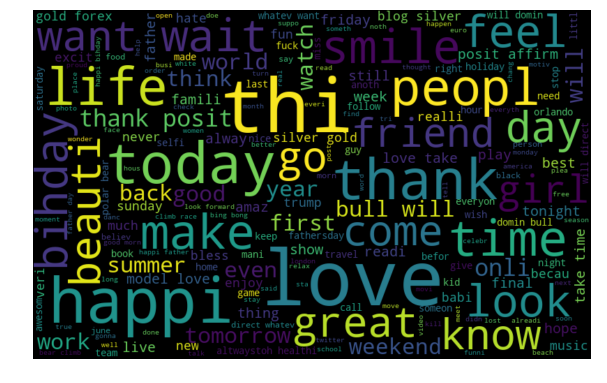

In [20]:
#all the words our data using the wordcloud plot
all_words = ' '.join([text for text in combi['tidy_tweet']]) 
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

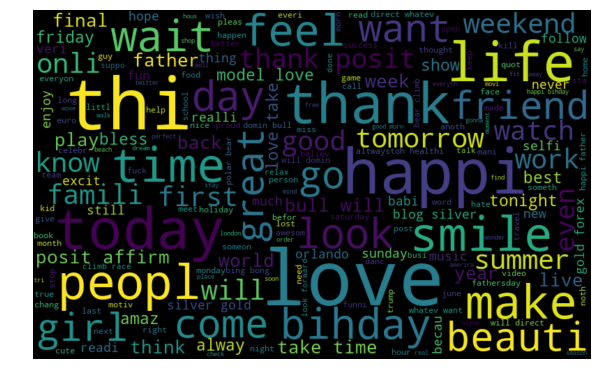

In [21]:
#Non racist/sexist tweets
normal_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]]) 
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

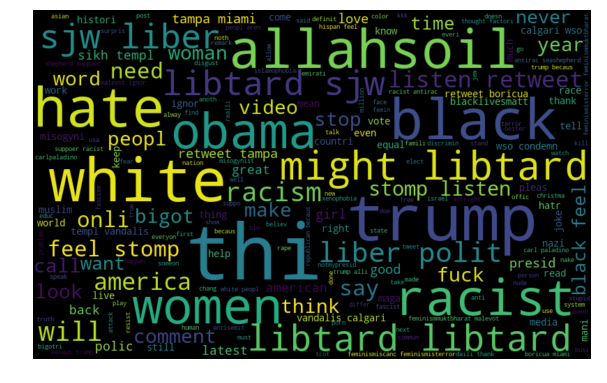

In [22]:
#Racist/Sexist Tweets
neagative_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]]) 
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neagative_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [23]:
# function to collect hashtags 
def hashtag_extract(x):    
    hashtags = []    
    # Loop over the words in the tweet    
    for i in x:        
        ht = re.findall(r"#(\w+)", i)        
        hashtags.append(ht)     
    return hashtags
# extracting hashtags from non racist/sexist tweets 
HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0]) 
# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1]) 
# unnesting list 
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

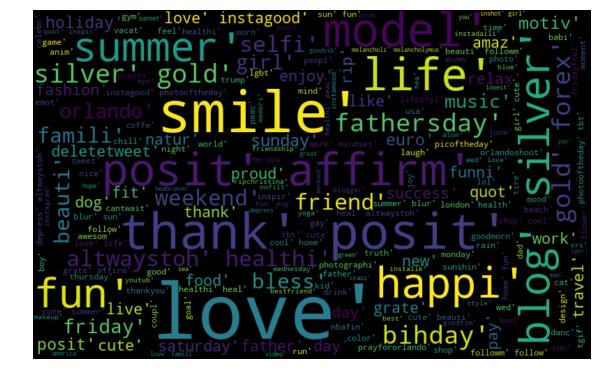

In [24]:
#Non-Racist/Sexist #Tweets using WordCloud
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(HT_regular)) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

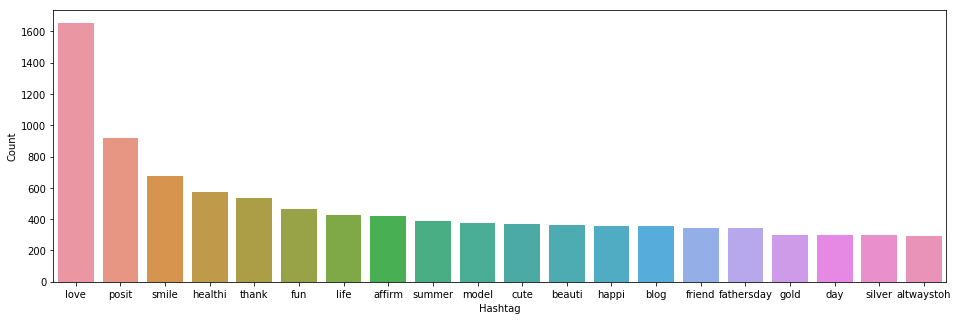

In [25]:
#Non-Racist/Sexist #Tweets barplot
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())}) 
# selecting top 20 most frequent hashtags
d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

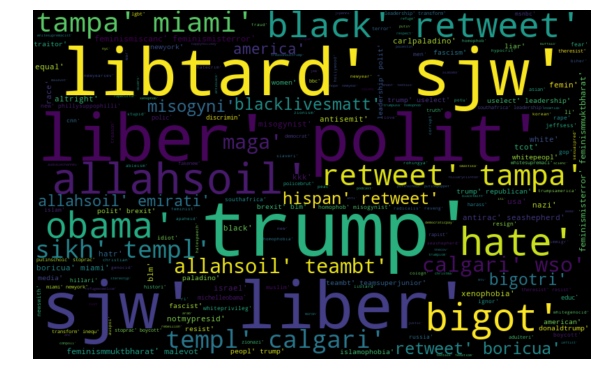

In [26]:
#Racist/Sexist #Tweets using WordCloud
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(HT_negative)) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

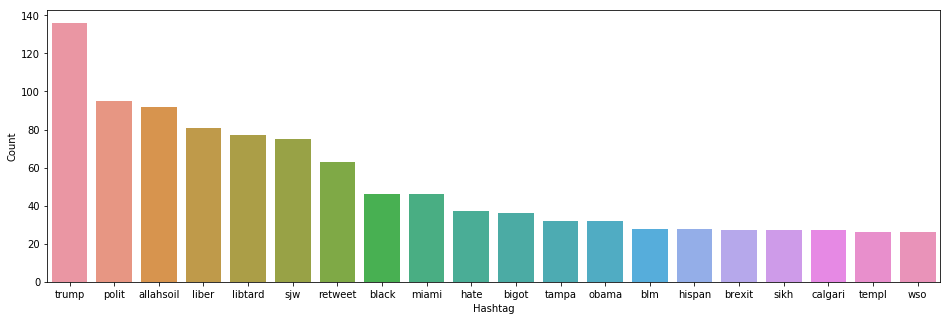

In [27]:
#Racist/Sexist #Tweets barplot
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())}) 
# selecting top 20 most frequent hashtags
d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [28]:
#train a Word2Vec model on our corpus.
import gensim

tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34) 

model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

(6510028, 7536020)

In [29]:
#function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary    
            continue
    if count != 0:
        vec /= count
    return vec

In [30]:
#Preparing word2vec feature set
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    wordvec_df = pd.DataFrame(wordvec_arrays)

wordvec_df.shape    

(49159, 200)

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
# splitting data into training and validation set
train_w2v = wordvec_df.iloc[:31962,:] 
test_w2v = wordvec_df.iloc[31962:,:] 
#xtrain_w2v = train_w2v.iloc[ytrain.index,:]
#xvalid_w2v = train_w2v.iloc[yvalid.index,:]
xtrain_w2v, xvalid_w2v, ytrain, yvalid = train_test_split(train_w2v, train['label'],
                                                          random_state=42,
                                                          test_size=0.3)




In [33]:
#Sentiment Analysis with XGBoost
#import XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [34]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain) 
prediction = xgb.predict(xvalid_w2v) 
f1_score(yvalid, prediction)

0.650994575045208